In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

print(pm.__version__)
print(az.__version__)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.6.1
0.15.1


In [2]:
train_classify = pd.read_csv('train_clf.csv')
test_classify = pd.read_csv('test_clf.csv')

In [3]:
display(train_classify.tail())
display(test_classify.head())

,a,b,c,y
95,2.491194,0.685869,3.200508,1.0
96,5.798723,6.416613,0.224369,0.0
97,6.553074,8.428001,-0.687934,0.0
98,1.441131,4.369016,-1.913370,1.0
99,1.699959,8.014732,-4.988070,1.0


,a,b,c
0,6.106970,8.712798,-1.523174
1,5.796587,10.704556,-3.947281
2,6.041652,6.628682,0.602950
3,2.201992,1.272898,1.716670
4,4.501528,3.148547,2.082501


In [4]:
X_train = np.array(train_classify[['a', 'b', 'c']])
y_train = np.array(train_classify['y'])
X_test = np.array(test_classify[['a', 'b', 'c']])

In [5]:
X_means = X_train.mean(axis=0)
X_1 = (X_train-X_means)

In [6]:
X_test_means = X_test.mean(axis=0)
X_test_1 = (X_test-X_test_means)

In [7]:
len(y_train)

100

### Задание 1

In [8]:
with pm.Model() as model_1: 
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=3) 
     
    μ = α_tmp + pm.math.dot(X_1, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    α = pm.Deterministic('α', α_tmp - pm.math.dot(β,X_means))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * (X_1[:,0]+X_means[0]))
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_train) 
 
    trace_1 = pm.sample(1000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,-0.652,0.742,-2.096,0.682,0.017,0.013,1992.0,1981.0,1.0
β[0],-2.329,1.248,-4.856,-0.139,0.037,0.026,1152.0,1650.0,1.0
β[1],-1.895,1.165,-4.144,0.239,0.035,0.025,1122.0,1523.0,1.0
β[2],0.008,1.081,-1.939,2.162,0.034,0.024,1013.0,1335.0,1.0
θ[0],0.001,0.003,0.000,0.004,0.000,0.000,2224.0,1888.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],10.953,90.095,-10.895,29.232,1.549,1.095,1728.0,1577.0,1.0
bd[96],0.616,77.724,-13.576,18.076,1.331,0.942,1683.0,1560.0,1.0
bd[97],-1.741,115.886,-24.209,23.109,1.988,1.406,1672.0,1563.0,1.0
bd[98],14.235,143.236,-17.534,45.403,2.461,1.740,1707.0,1563.0,1.0


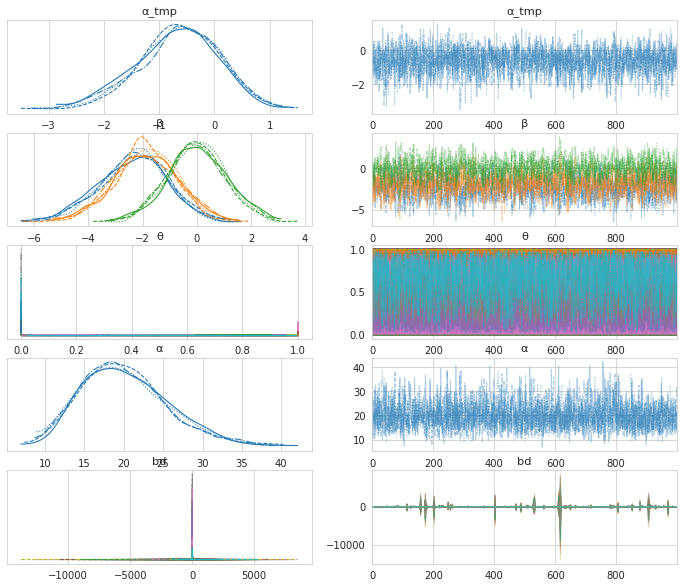

In [9]:
az.plot_trace(trace_1);
az.summary(trace_1)

In [31]:
posterior_1 = trace_1.posterior.stack(samples=("chain", "draw"))

In [32]:
posterior_1['θ'].values.T

array([[6.73719115e-04, 2.89811032e-07, 9.99969237e-01, ...,
        1.49269670e-04, 9.98531275e-01, 8.11339974e-01],
       [3.09047275e-05, 2.99383415e-10, 9.99999991e-01, ...,
        3.21089662e-06, 9.99980477e-01, 8.28188672e-01],
       [4.65868536e-05, 5.95461472e-10, 9.99999978e-01, ...,
        5.12948668e-06, 9.99976940e-01, 8.93526817e-01],
       ...,
       [2.92083166e-03, 1.12348140e-05, 9.99954668e-01, ...,
        9.64435097e-04, 9.95047175e-01, 4.97229326e-01],
       [1.02166784e-04, 6.39256207e-09, 9.99999927e-01, ...,
        1.49625524e-05, 9.99958925e-01, 9.26429955e-01],
       [5.40150140e-03, 2.36364707e-05, 9.99884329e-01, ...,
        1.83229023e-03, 9.97940758e-01, 9.30178494e-01]])

In [42]:
def classify(X, threshold):

    X = np.array(X)
    μ = posterior_1['α'].mean().values + posterior_1['β'].mean(axis=1).values.T @ np.transpose(X)
    prob = 1 / (1 + np.exp(-μ)) 
    
    return prob, np.where(prob >= threshold,1,0)

In [36]:
X_test_1

array([[ 1.44714469,  3.86569754, -2.36217607],
       [ 1.13676137,  5.85745632, -4.78628286],
       [ 1.38182612,  1.781582  , -0.23605202],
       [-2.45783362, -3.57420202,  0.87766836],
       [-0.15829769, -1.69855349,  1.24349919],
       [-1.98650867, -2.4601026 ,  1.33682065],
       [ 3.96720903, -0.30882868,  4.99144516],
       [-3.37524492, -4.29503608,  1.26026505],
       [-0.62424219, -1.15088512,  0.88998809],
       [ 2.5343297 ,  4.09018994, -1.36982196],
       [ 0.21556717,  3.10008482, -2.91841075],
       [-1.57808025, -4.06233596,  2.14749286],
       [-3.31281276,  2.3919318 , -5.53634368],
       [ 6.07172362,  3.1005658 ,  2.82389459],
       [-2.71820008, -3.7066122 ,  0.96492326],
       [-3.79113671, -1.64827325, -2.26720407],
       [ 2.46063502,  7.07938418, -4.8722454 ],
       [-3.12244237,  2.06217164, -5.1151234 ],
       [ 4.26692686,  2.97846181,  1.79667619],
       [ 0.77366801,  1.50877692, -0.9678332 ],
       [-3.94579171, -1.16662069, -2.838

In [51]:
number = 0.99999999999999
classify(X_test_1, number)

(array([0.99992544, 0.99839684, 0.99999879, 1.        , 1.        ,
        1.        , 0.99999084, 1.        , 1.        , 0.99857763,
        0.999999  , 1.        , 1.        , 0.5554427 , 1.        ,
        1.        , 0.73785924, 1.        , 0.99052419, 0.99999982,
        1.        , 0.99999962, 1.        , 0.99984434, 0.99999998,
        0.99997181, 0.99999959, 0.99988374, 1.        , 1.        ,
        1.        , 0.99999997, 1.        , 0.99972748, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99999765,
        0.99999891, 1.        , 0.99998905, 0.99999986, 1.        ,
        1.        , 0.99567342, 0.9999999 , 1.        , 0.99994162,
        1.        , 1.        , 0.99999955, 1.        , 1.        ,
        1.        , 1.        , 0.99999932, 1.        , 0.99999946,
        1.        , 0.99978023, 1.        , 0.99999722, 0.95918897,
        1.        , 0.99999992, 1.        , 0.999984  , 1.        ,
        0.99999978, 1.        , 1.        , 0.99

### Задание 2

In [53]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=3)
    σ = pm.HalfNormal('σ', 10, shape=3)
    a = pm.Normal('a', mu=μ[0], sigma=σ[0], observed=X_train[:34]) 
    b = pm.Normal('b', mu=μ[1], sigma=σ[1], observed=X_train[34:67]) 
    c = pm.Normal('c', mu=μ[2], sigma=σ[2], observed=X_train[67:]) 
    
    bd = pm.Deterministic('bd', (μ[0] + μ[1] + μ[2]) / 3)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


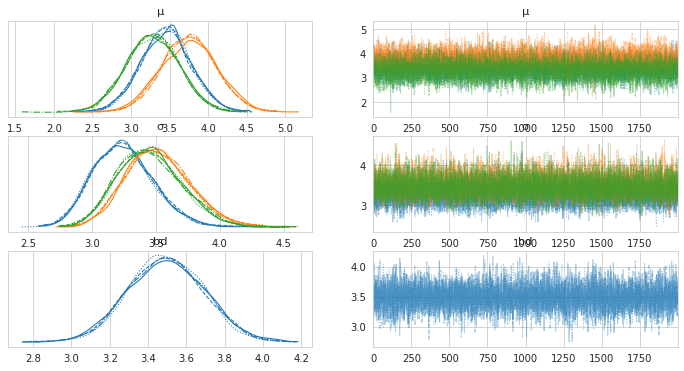

In [54]:
az.plot_trace(trace_lda);

In [55]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],3.454,0.326,2.841,4.070,0.003,0.002,13245.0,6788.0,1.0
μ[1],3.751,0.355,3.070,4.397,0.004,0.002,10239.0,6740.0,1.0
μ[2],3.280,0.342,2.625,3.900,0.003,0.002,9946.0,6858.0,1.0
σ[0],3.246,0.237,2.823,3.698,0.003,0.002,8597.0,6053.0,1.0
σ[1],3.517,0.253,3.063,4.006,0.002,0.002,11036.0,6706.0,1.0
σ[2],3.454,0.252,2.986,3.911,0.002,0.002,11555.0,6249.0,1.0
bd,3.495,0.198,3.119,3.853,0.002,0.001,11117.0,7019.0,1.0


In [57]:
with lda:
    y_pred = pm.sample_posterior_predictive(trace_lda)

Sampling: [a, b, c]


In [58]:
y_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

In [61]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

In [62]:
def classify(X, threshold):

    X = np.array(X)
    μ = posterior_1['α'].mean().values + posterior_1['β'].mean(axis=1).values.T @ np.transpose(X)
    prob = 1 / (1 + np.exp(-μ)) 
    
    return prob, np.where(prob >= threshold,1,0)

In [63]:
number = 0.99999999999999
classify(X_test_1, number)

(array([0.99992544, 0.99839684, 0.99999879, 1.        , 1.        ,
        1.        , 0.99999084, 1.        , 1.        , 0.99857763,
        0.999999  , 1.        , 1.        , 0.5554427 , 1.        ,
        1.        , 0.73785924, 1.        , 0.99052419, 0.99999982,
        1.        , 0.99999962, 1.        , 0.99984434, 0.99999998,
        0.99997181, 0.99999959, 0.99988374, 1.        , 1.        ,
        1.        , 0.99999997, 1.        , 0.99972748, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99999765,
        0.99999891, 1.        , 0.99998905, 0.99999986, 1.        ,
        1.        , 0.99567342, 0.9999999 , 1.        , 0.99994162,
        1.        , 1.        , 0.99999955, 1.        , 1.        ,
        1.        , 1.        , 0.99999932, 1.        , 0.99999946,
        1.        , 0.99978023, 1.        , 0.99999722, 0.95918897,
        1.        , 0.99999992, 1.        , 0.999984  , 1.        ,
        0.99999978, 1.        , 1.        , 0.99